In [1]:
def categorize_corr(corr):
    '''Convert corrugation (float) into a class'''
    corr = float(corr)
    assert (corr >= 0)
    if corr < 0.50:
        cat = 0
    elif corr < 1.0:
        cat = 1
    elif corr < 1.50:
        cat = 2
    else:
        cat = 3
    return cat

def top_acc_w_tie(acc_scaling_law, n_samples):
    '''Extracts reference dataset sizes and computes top1, top1_w_tiebreak and top5 acc
    from acc_scaling_law dict.
    ARGS: acc_scaling_law: dictionary containing the CID for which the identification fails
          n_samples: number of samples to identify'''
    ref_sizes = list(acc_scaling_law.keys())
    top_1_acc = np.zeros(len(ref_sizes))
    top_1_acc_reorder = np.zeros(len(ref_sizes))
    top_5_acc = np.zeros(len(ref_sizes))
    top_5_acc_reorder = np.zeros(len(ref_sizes))
    
    for i, ref_size in enumerate(ref_sizes):
        top_1_acc[i] =  len(acc_scaling_law[ref_size]['top_1_mistakes'])
        top_1_acc_reorder[i] =  len(acc_scaling_law[ref_size]['top_1_mistakes_reorder'])
        top_5_acc[i] =  len(acc_scaling_law[ref_size]['top_5_mistakes'])
        top_5_acc_reorder[i] =  len(acc_scaling_law[ref_size]['top_5_mistakes_reorder'])

    
    top_1_acc = (1 - top_1_acc/n_samples)*100
    top_1_acc_reorder = (1 - top_1_acc_reorder/n_samples)*100
    top_5_acc = (1 - top_5_acc/n_samples)*100
    top_5_acc_reorder = (1 - top_5_acc_reorder/n_samples)*100

    return ref_sizes, top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder

def top_acc_corr_cat(samples_df, top_1_mistakes, top_1_mistakes_reorder, top_5_mistakes, top_5_mistakes_reorder):
    '''Compute the top1 and top5 accuracy segregating by corr_cat
    ARGS:
            samples_df: dictonary contianing the CID and corrugation category of the
                        molecules for which identification is performed.
            top_{1,5}_mistakes: list of CID where the reference was not in the top {1,5} candidates'''
    
    corr_cat_top1 = list()
    corr_cat_top1_reorder = list()
    corr_cat_top5 = list()
    corr_cat_top5_reorder = list()
    for CID in top_1_mistakes:
        corr_cat_top1.append(int(samples_df[samples_df['CID'] == CID]['corr_cat']))
    
    for CID in top_1_mistakes_reorder:
        corr_cat_top1_reorder.append(int(samples_df[samples_df['CID'] == CID]['corr_cat']))
    
    for CID in top_5_mistakes:
        corr_cat_top5.append(int(samples_df[samples_df['CID'] == CID]['corr_cat']))
        
    for CID in top_5_mistakes_reorder:
        corr_cat_top5_reorder.append(int(samples_df[samples_df['CID'] == CID]['corr_cat']))
        
    count_top1 = Counter(corr_cat_top1)
    count_top1_reorder = Counter(corr_cat_top1_reorder)
    count_top5 = Counter(corr_cat_top5)
    count_top5_reorder = Counter(corr_cat_top5_reorder)
    
    corr_cat_counter = Counter(samples_df['corr_cat']) #total number of samples corresponding to each category
    
    top_1_acc = dict()
    top_1_acc_reorder = dict()
    top_5_acc = dict() 
    top_5_acc_reorder = dict()

    for key in corr_cat_counter.keys():
        top_1_acc[key] = (1-count_top1[key]/corr_cat_counter[key])*100
        top_1_acc_reorder[key] = (1-count_top1_reorder[key]/corr_cat_counter[key])*100
        top_5_acc[key] = (1-count_top5[key]/corr_cat_counter[key])*100
        top_5_acc_reorder[key] = (1-count_top5_reorder[key]/corr_cat_counter[key])*100
    top_1_acc = {k: v for k, v in sorted(top_1_acc.items())}
    top_1_acc_reorder = {k: v for k, v in sorted(top_1_acc_reorder.items())}
    top_5_acc = {k: v for k, v in sorted(top_5_acc.items())}
    top_5_acc_reorder = {k: v for k, v in sorted(top_5_acc_reorder.items())}

    return top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder

In [2]:
# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import pickle
from collections import Counter
import matplotlib.font_manager as fm
import sys
sys.path.append('../../.')
from utils.screening import tanimoto_numpy, fp_screening_function

print('Packages loaded')

/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Packages loaded


/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
#data
data_path = '../../data/dataset/285k_train_15k_fp_and_atom_counts_w_H.gz'
dataset_df = pd.read_pickle(data_path)


In [4]:
with open('../../data/calculations/acc_top10_all_test.pickle', 'rb') as handle:
    acc_scaling_law = pickle.load(handle)

In [5]:
print(acc_scaling_law.keys())
acc_scaling_law[279848]

dict_keys([279848])


{'top_1_mistakes': [129712445,
  59383542,
  59383547,
  59390182,
  100822,
  101725283,
  102393,
  123683583,
  60134116,
  138831,
  58830918,
  58830949,
  13000274,
  13000286,
  123350949,
  136762336,
  12761319,
  12761330,
  12761531,
  85669101,
  123044,
  123908185,
  123911932,
  123912520,
  54300247,
  543014,
  134982501,
  134982825,
  134983592,
  22448215,
  123473743,
  123475825,
  129671794,
  13766965,
  13766967,
  129829073,
  129829432,
  129829435,
  23592500,
  59854140,
  59854142,
  59854147,
  123757801,
  59645563,
  58774645,
  85985737,
  85986644,
  85988850,
  85989461,
  124034542,
  54097614,
  54098412,
  126650924,
  135897203,
  135899568,
  129645177,
  129774538,
  22087375,
  134867626,
  59270990,
  129868456,
  130475637,
  23523247,
  58656424,
  12340268,
  123967434,
  59787205,
  59787227,
  59787244,
  123284874,
  123285067,
  13766984,
  85807103,
  71333029,
  71334116,
  18310,
  183178,
  564910,
  2751855,
  123147429,
  1231479

In [6]:
test_df = dataset_df[dataset_df['split'] == 'test']
N_SAMPLES = len(test_df)
N_SAMPLES

279848

In [7]:
test_df['corr_cat'] = [categorize_corr(x) for x in test_df['corrugation']]
Counter(test_df['corr_cat'])

Counter({2: 38951, 0: 208034, 1: 29686, 3: 3177})

In [8]:
Counter(dataset_df['split'])

Counter({'test': 279848})

In [9]:
train_df = dataset_df[dataset_df['split'] == 'train']
train_df['corr_cat'] = [categorize_corr(x) for x in train_df['corrugation']]
Counter(train_df['corr_cat'])

Counter()

In [10]:
print(acc_scaling_law[279848].keys())
top1 = 100*(1-len(acc_scaling_law[279848]['top_5_mistakes_reorder'])/N_SAMPLES)
print(top1)

dict_keys(['top_1_mistakes', 'top_5_mistakes', 'top_1_mistakes_reorder', 'top_5_mistakes_reorder'])
98.35803722020525


In [11]:


ref_sizes, top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder =  top_acc_w_tie(acc_scaling_law, N_SAMPLES)
print(ref_sizes, '\n',
      top_1_acc, '\n',
      top_1_acc_reorder, '\n',
      top_5_acc, '\n',
      top_5_acc_reorder, '\n',
     )


[279848] 
 [95.42644578] 
 [97.58511764] 
 [97.92244361] 
 [98.35803722] 



In [12]:
top_1_mistakes =  acc_scaling_law[np.max(ref_sizes)]['top_1_mistakes']
top_1_mistakes_reorder =  acc_scaling_law[np.max(ref_sizes)]['top_1_mistakes_reorder']
top_5_mistakes =  acc_scaling_law[np.max(ref_sizes)]['top_5_mistakes']
top_5_mistakes_reorder =  acc_scaling_law[np.max(ref_sizes)]['top_5_mistakes_reorder']

In [13]:
top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder = top_acc_corr_cat(test_df, 
                                                                      top_1_mistakes, top_1_mistakes_reorder, 
                                                                      top_5_mistakes, top_5_mistakes_reorder)
print(top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder)

{0: 96.17706721016756, 1: 91.88169507511958, 2: 94.89615157505584, 3: 85.89864652187599} {0: 98.13395887210744, 1: 95.43219025803408, 2: 96.94744679212344, 3: 89.5813660686182} {0: 98.41948912197044, 1: 95.69494037593478, 2: 97.52509563297477, 3: 91.06074913440352} {0: 98.78337194881605, 1: 96.48319072963687, 2: 98.02315730019768, 3: 92.13094113943973}


In [14]:
# Melt the dataframe to show top1 acc, top1 acc chem formula, top5 acc and top5 acc chem formula in the same column
data = {'Corrugation': list(top_1_acc.keys()), 'top1 acc': list(top_1_acc.values()),
        'top1 acc chem formula': list(top_1_acc_reorder.values()), 'top5 acc': list(top_5_acc.values()), 
       'top5 acc chem formula': list(top_5_acc_reorder.values()),}
df = pd.DataFrame(data)

df = pd.melt(df, id_vars=['Corrugation'], value_vars=['top1 acc', 'top1 acc chem formula', 'top5 acc', 'top5 acc chem formula'], var_name='Accuracy')
df['value'] = df['value']/100 

# Separate dataframes for 'top1 acc', 'top1 acc chem formula', 'top5 acc' and 'top5 acc chem formula'
df_top1 = df[df['Accuracy'] == 'top1 acc']
df_top1_formula = df[df['Accuracy'] == 'top1 acc chem formula']
df_top5 = df[df['Accuracy'] == 'top5 acc']
df_top5_formula = df[df['Accuracy'] == 'top5 acc chem formula']


In [15]:

# Melt the dataframe to show top1 acc, top1 acc chem formula, top5 acc and top5 acc chem formula in the same column
data = {'Corrugation': [r'$<50\,pm$', r'$50-100\,pm$', r'$100-150\,pm$', r'$>150\,pm$'], 'top1 acc': list(top_1_acc.values()),
        'top1 acc chem formula': list(top_1_acc_reorder.values()), 'top5 acc': list(top_5_acc.values()), 
       'top5 acc chem formula': list(top_5_acc_reorder.values()),}
df = pd.DataFrame(data)
print(df)

     Corrugation   top1 acc  top1 acc chem formula   top5 acc  \
0      $<50\,pm$  96.177067              98.133959  98.419489   
1   $50-100\,pm$  91.881695              95.432190  95.694940   
2  $100-150\,pm$  94.896152              96.947447  97.525096   
3     $>150\,pm$  85.898647              89.581366  91.060749   

   top5 acc chem formula  
0              98.783372  
1              96.483191  
2              98.023157  
3              92.130941  


In [16]:
data = {'Corrugation': [r'$<50$ pm', r'$50-100$ pm', r'$100-150$ pm', r'$>150$ pm'], 'top1 acc': list(top_1_acc.values()),
        'top1 acc chem formula': list(top_1_acc_reorder.values()), 'top5 acc': list(top_5_acc.values()), 
       'top5 acc chem formula': list(top_5_acc_reorder.values()),}


df = pd.DataFrame(data)
# Round the accuracy values to two decimal places
df['top1 acc'] = df['top1 acc'].round(decimals=2)
df['top1 acc chem formula'] = df['top1 acc chem formula'].round(decimals=2)
df['top5 acc'] = df['top5 acc'].round(decimals=2)
df['top5 acc chem formula'] = df['top5 acc chem formula'].round(decimals=2)
print(df)

    Corrugation  top1 acc  top1 acc chem formula  top5 acc  \
0      $<50$ pm     96.18                  98.13     98.42   
1   $50-100$ pm     91.88                  95.43     95.69   
2  $100-150$ pm     94.90                  96.95     97.53   
3     $>150$ pm     85.90                  89.58     91.06   

   top5 acc chem formula  
0                  98.78  
1                  96.48  
2                  98.02  
3                  92.13  


$<50$ pm
[96.17706721016756, 98.13395887210744, 98.41948912197044, 98.78337194881605]
$50-100$ pm
[91.88169507511958, 95.43219025803408, 95.69494037593478, 96.48319072963687]
$100-150$ pm
[94.89615157505584, 96.94744679212344, 97.52509563297477, 98.02315730019768]
$>150$ pm
[85.89864652187599, 89.5813660686182, 91.06074913440352, 92.13094113943973]
    Corrugation  top1 acc  top1 acc chem formula  top5 acc  \
0      $<50$ pm     96.18                  98.13     98.42   
1   $50-100$ pm     91.88                  95.43     95.69   
2  $100-150$ pm     94.90                  96.95     97.53   
3     $>150$ pm     85.90                  89.58     91.06   

   top5 acc chem formula  
0                  98.78  
1                  96.48  
2                  98.02  
3                  92.13  


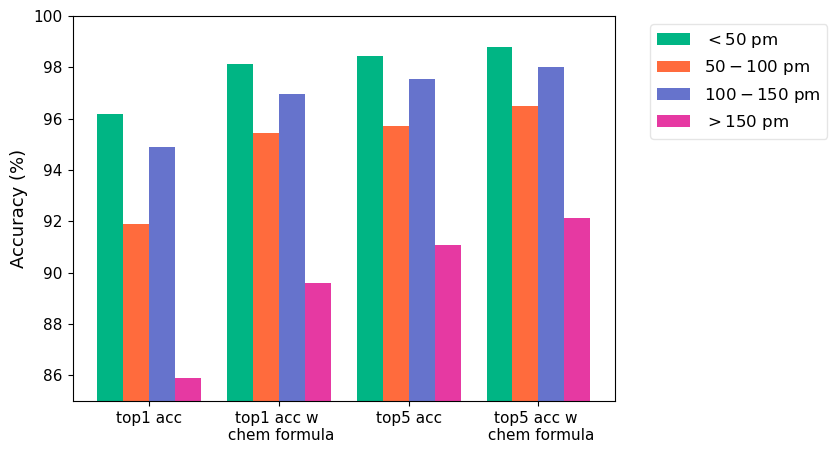

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
width = 0.2  # width of the bars
distance_list = np.arange(4)
color_list = ['#00b584', '#ff6b3d', '#6673cc', '#e639a2']
for i in distance_list:
    corrugation = data['Corrugation'][i]
    acc_list = [data['top1 acc'][i], data['top1 acc chem formula'][i], 
                data['top5 acc'][i], data['top5 acc chem formula'][i]]
    print(corrugation)
    print(acc_list)
    bar1 = ax.bar(distance_list+(i-1)*width, acc_list, width, label=corrugation, color=color_list[i], capsize=5)
#bar2 = ax.bar(distance_list , df_top5['value'], width, label='top5', color='b', capsize=5)
#bar3 = ax.bar(distance_list + width, df_top1_formula['value'], width, label='top1 w chem formula', color='g', capsize=5)
#bar4 = ax.bar(distance_list + 2*width, df_top5_formula['value'], width, label='top5 w chem formula', color='m', capsize=5)

#ax.set_xlabel('Corrugation ($\AA$)', fontsize=13)
ax.set_ylabel('Accuracy (%)', fontsize=13)
ax.set_ylim(85, 100)
ax.set_xticks(distance_list + width / 2)
ax.set_xticklabels(['top1 acc', 'top1 acc w \n chem formula', 'top5 acc', 'top5 acc w \n chem formula'])

ax.legend(fontsize=12, framealpha=0.5,fancybox=True, bbox_to_anchor=(1.05, 1.0))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# Display the plot
print(df)
##plt.savefig(f'/home/{USER}/CODE/Pytorch-fingerprints/figures/top1_and_5_reorder_chem_corrugation_legend_outside.pdf', format="pdf", bbox_inches="tight")

plt.show()

In [18]:
ref_sizes, top_1_acc, top_1_acc_reorder, top_5_acc, top_5_acc_reorder =  top_acc_w_tie(acc_scaling_law, N_SAMPLES)
print(ref_sizes, '\n',
      top_1_acc, '\n',
      top_1_acc_reorder, '\n',
      top_5_acc, '\n',
      top_5_acc_reorder, '\n',)

[279848] 
 [95.42644578] 
 [97.58511764] 
 [97.92244361] 
 [98.35803722] 



In [19]:
indices = ['top1', 'top1 w chemical', 'top5', 'top5 w chemical']
accuracies = [top_1_acc[0], top_1_acc_reorder[0], top_5_acc[0], top_5_acc_reorder[0]]

# Create a DataFrame with the indices
accuracies_df = pd.DataFrame({'labels': indices,
                             'acc': accuracies})

# Print the DataFrame
print(accuracies_df)
# y-positions for the horizontal lines
y_positions = accuracies

            labels        acc
0             top1  95.426446
1  top1 w chemical  97.585118
2             top5  97.922444
3  top5 w chemical  98.358037


$<50$ pm
[96.17706721016756, 98.13395887210744, 98.41948912197044, 98.78337194881605]
$50-100$ pm
[91.88169507511958, 95.43219025803408, 95.69494037593478, 96.48319072963687]
$100-150$ pm
[94.89615157505584, 96.94744679212344, 97.52509563297477, 98.02315730019768]
$>150$ pm
[85.89864652187599, 89.5813660686182, 91.06074913440352, 92.13094113943973]
    Corrugation  top1 acc  top1 acc chem formula  top5 acc  \
0      $<50$ pm     96.18                  98.13     98.42   
1   $50-100$ pm     91.88                  95.43     95.69   
2  $100-150$ pm     94.90                  96.95     97.53   
3     $>150$ pm     85.90                  89.58     91.06   

   top5 acc chem formula  
0                  98.78  
1                  96.48  
2                  98.02  
3                  92.13  


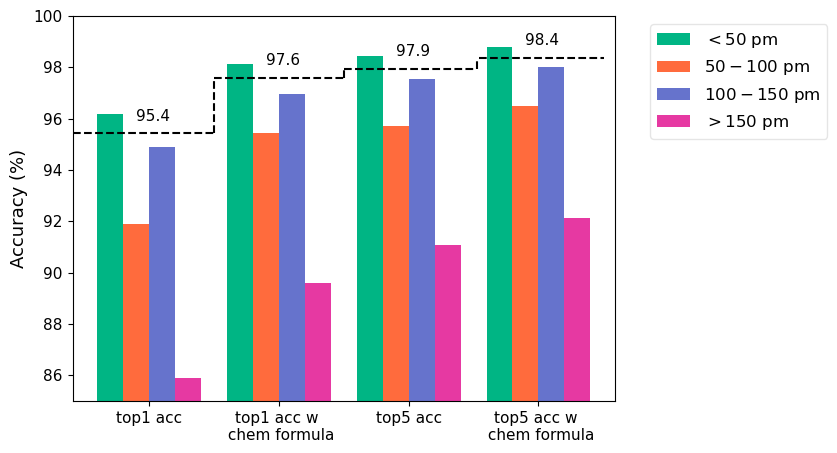

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
width = 0.2  # width of the bars
distance_list = np.arange(4)
color_list = ['#00b584', '#ff6b3d', '#6673cc', '#e639a2']
for i in distance_list:
    corrugation = data['Corrugation'][i]
    acc_list = [data['top1 acc'][i], data['top1 acc chem formula'][i], 
                data['top5 acc'][i], data['top5 acc chem formula'][i]]
    print(corrugation)
    print(acc_list)
    bar1 = ax.bar(distance_list+(i-1)*width, acc_list, width, label=corrugation, color=color_list[i], capsize=5)
#bar2 = ax.bar(distance_list , df_top5['value'], width, label='top5', color='b', capsize=5)
#bar3 = ax.bar(distance_list + width, df_top1_formula['value'], width, label='top1 w chem formula', color='g', capsize=5)
#bar4 = ax.bar(distance_list + 2*width, df_top5_formula['value'], width, label='top5 w chem formula', color='m', capsize=5)

#ax.set_xlabel('Corrugation ($\AA$)', fontsize=13)


ax.set_ylabel('Accuracy (%)', fontsize=13)

ax.set_ylim(85, 100)
ax.set_xticks(distance_list + width / 2)
ax.set_xticklabels(['top1 acc', 'top1 acc w \n chem formula', 'top5 acc', 'top5 acc w \n chem formula'], fontsize=15)

# Setting the font size for x-ticks and y-ticks
ax.tick_params(axis='x', labelsize=15)  # Set x-ticks font size
ax.tick_params(axis='y', labelsize=15)  # Set y-ticks font size

ax.legend(fontsize=12, framealpha=0.5,fancybox=True, bbox_to_anchor=(1.05, 1.0))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# Display the plot
print(df)
##plt.savefig(f'/home/{USER}/CODE/Pytorch-fingerprints/figures/top1_and_5_reorder_chem_corrugation_legend_outside.pdf', format="pdf", bbox_inches="tight")

# Calculate the mean for each accuracy type
mean_top1_acc = accuracies_df['acc'].iloc[0]
mean_top1_acc_formula = accuracies_df['acc'].iloc[1]
mean_top5_acc = accuracies_df['acc'].iloc[2]
mean_top5_acc_formula = accuracies_df['acc'].iloc[3]



## Draw horizontal lines for the mean values
#ax.axhline(mean_top1_acc, color='k', linestyle='--', xmin=0, xmax=0.26) # Limiting line length for clarity
#ax.axhline(mean_top1_acc_formula, color='k', linestyle='--', xmin=0.26, xmax=0.50)
#ax.axhline(mean_top5_acc, color='k', linestyle='--', xmin=0.50,xmax=0.74)
#ax.axhline(mean_top5_acc_formula, color='k', linestyle='--',  xmin=0.74, xmax=0.98)

# If you want to add labels to the mean lines:
ax.text(0, mean_top1_acc + 0.5, f'{mean_top1_acc:.1f}', color='k', fontsize = 11)
ax.text(1, mean_top1_acc_formula + 0.5, f'{mean_top1_acc_formula:.1f}', color='k', fontsize = 11)
ax.text(2, mean_top5_acc + 0.5, f'{mean_top5_acc:.1f}', color='k', fontsize = 11)
ax.text(3, mean_top5_acc_formula + 0.5, f'{mean_top5_acc_formula:.1f}', color='k', fontsize = 11)

# x-position bounds for the horizontal lines
x_positions = [(0, 0.26), (0.26, 0.50), (0.50, 0.74), (0.75, 0.98)]
y_positions_old = [mean_top1_acc, mean_top1_acc_formula, mean_top5_acc]

y_positions_new = [mean_top1_acc_formula, mean_top5_acc, mean_top5_acc_formula]

# Draw horizontal lines
hor_lines = [
    ax.axhline(y, color='k', linestyle='--', xmin=xmin, xmax=xmax)
    for y, (xmin, xmax) in zip(y_positions, x_positions)
]
# List to capture the x-coordinates of vertical lines
vertical_x_positions = []

# Get the positions of bars and calculate vertical lines' x-coordinates
for i in range(len(distance_list) - 1):
    right_edge_current_bar = distance_list[i] + width
    left_edge_next_bar = distance_list[i + 1]
    
    # Midpoint between two bars
    midpoint = (right_edge_current_bar + left_edge_next_bar) / 2
    vertical_x_positions.append(midpoint)

# List to capture the x-coordinates of vertical lines
vertical_x_positions = []

# Get the positions of bars and calculate vertical lines' x-coordinates
for i in range(len(distance_list) - 1):
    right_edge_current_bar = distance_list[i] + width
    left_edge_next_bar = distance_list[i + 1]
    
    # Midpoint between two bars
    midpoint = (right_edge_current_bar + left_edge_next_bar) / 2
    vertical_x_positions.append(midpoint)

# For each calculated x-coordinate, draw the vertical connecting line
for idx, x_intersection in enumerate(vertical_x_positions):
    # y-coordinates of the two intersecting horizontal lines
    y_start = hor_lines[idx].get_ydata()[0]
    y_end = hor_lines[idx + 1].get_ydata()[0]

    # Calculate ymin and ymax as fractions of the y-axis
    ymin_fraction = (y_start - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0])
    ymax_fraction = (y_end - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Draw the vertical connecting line
    if idx == 2:
        ax.axvline(x=x_intersection+0.03, ymin=ymin_fraction, ymax=ymax_fraction, color='k', linestyle='--')
    else:
        ax.axvline(x=x_intersection, ymin=ymin_fraction, ymax=ymax_fraction, color='k', linestyle='--')



#plt.savefig(f'/home/{USER}/CODE/Pytorch-fingerprints/figures/accuracy corrugation/accuracy_corrugation_reframing_mean_ALL_TESTSET_other_corrugations.pdf', format="pdf", bbox_inches="tight")


plt.show()
plt.close()
